In [13]:
import os
PATH = '/home/maa/Documents/GitHub/works/Air_Liquide'
os.chdir(PATH)

import numpy as np
import pandas as pd
from preprocessing.preprocessing import preprocess_data
from utils.data_loading import load_data
from models.model import build_model
from utils.model_evaluation import evaluate_model_rnn
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from joblib import dump

2023-07-08 17:31:11.987019: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 17:31:18.101357: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 17:31:18.111252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 17:31:29.977355: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Installer airflow et le connecter a Postgresql

https://medium.com/geekculture/apache-airflow-2-0-complete-installation-with-wsl-explained-71a65d509aba


In [79]:
import psycopg2, os, requests
from datetime import date, timedelta, datetime
import pandas as pd
from airflow.utils.dates import days_ago
from datetime import timedelta, datetime


In [47]:
def update_data():
    """
    S'assurer que le fichier AI.PA.csv est à jour. A cette étape, le remplacer manuellement. TODO: Trouver une solution de le remplacer automatiquement
    """
    # Établir une connexion à la base de données
    conn = psycopg2.connect(
        host="localhost",
        port="5432",
        database="AirLiquide",
        user="postgres"
    )
    # Créer un curseur pour exécuter les requêtes
    cur = conn.cursor()

    # dernière date dans en bdd
    cur.execute("SELECT max(date) FROM raw_data")
    derniere_date_bdd = cur.fetchone()[0]
    print('derniere date en bdd:', derniere_date_bdd)

    # dernière date renseignée en ligne
    df = pd.read_csv('/home/maa/Documents/GitHub/works/Air_Liquide/data/AI.PA.csv', parse_dates=['Date'])
    df = df.sort_values('Date', ascending=False).reset_index(drop=True)[['Date','Low']]
    derniere_date_a_jour = df.Date[0].date()
    print('dernière date du fichier:', derniere_date_a_jour)

    # Dates à mettre à jour
    dates_maj = []
    date_origine = derniere_date_bdd
    while derniere_date_bdd <= derniere_date_a_jour:
        if derniere_date_bdd != date_origine:
            dates_maj.append(derniere_date_bdd.strftime('%Y-%m-%d'))
        derniere_date_bdd += timedelta(days=1)

    print("Démarrage de la mise à jour:\n")

    if dates_maj != []:

        for d in dates_maj:
            print(str(d))
            if d in str(df.date):
                low = df[df.Date == d]['Low'].iloc[0]
                cur.execute("INSERT INTO raw_data (date, low) VALUES (%s, %s)", (d, low))
            else:
                print('Date non renseignée')
        print("Done")
    else:
        print("Aucune date manquante!")
    # Valider la transaction
    conn.commit()

    # Fermer le curseur et la connexion à la base de données
    cur.close()
    conn.close()

    return "raw_data updated to " + str(derniere_date_a_jour)



In [92]:

def download_file():
    """
    Télécharge le fichier AI.PA.csv depuis Yahoo Finance et le sauvegarde dans /home/maa/Documents/GitHub/works/Air_Liquide/data/
    """
    url = "https://query1.finance.yahoo.com/v7/finance/download/AI.PA"
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }
    
    dest_folder = "/home/maa/Documents/GitHub/works/Air_Liquide/data/"
    dest_folder = "/home/maa/Téléchargements/"
    filename = "AI.PA.csv"

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        with open(os.path.join(dest_folder, filename), 'wb') as f:
            f.write(response.content)
        print("Fichier AI.PA.csv téléchargé avec succès.")
    else:
        print("Impossible de télécharger le fichier AI.PA.csv depuis Yahoo Finance.")


In [95]:
download_file()

Fichier AI.PA.csv téléchargé avec succès.


In [194]:

# générateur de validation croisée
n_folds = 5
tscv = TimeSeriesSplit(n_splits=n_folds)
scores = []        

# boucle sur les splits de la cross-validation
for train_index, val_index in tscv.split(train_data):
    # Création des générateurs pour l'ensemble d'entraînement et de validation
    train_gen = TimeseriesGenerator(train_data.values[train_index], train_data.values[train_index], length=length, batch_size=batch_size)
    val_gen = TimeseriesGenerator(train_data.values[val_index], train_data.values[val_index], length=length, batch_size=batch_size)

    # Entraînement du modèle sur l'ensemble d'entraînement
    model.fit(train_gen, epochs=10, callbacks=[early_stop]) #, verbose=0)

    # Évaluation du modèle sur l'ensemble de validation
    score = model.evaluate(val_gen, verbose=0)
    scores.append(score)
    
# Évaluation globale de la performance de la cross-validation
print("Moyenne des scores de la cross-validation : %.2f%%" % (np.mean(scores)*100))

Epoch 1/10
973/973 [==============================] - 12s 11ms/step - loss: 2.9221
Epoch 2/10
973/973 [==============================] - 11s 11ms/step - loss: 1.0094
Epoch 3/10
973/973 [==============================] - 11s 11ms/step - loss: 0.6944
Epoch 4/10
973/973 [==============================] - 11s 11ms/step - loss: 0.6039
Epoch 5/10
973/973 [==============================] - 10s 11ms/step - loss: 0.5504
Epoch 6/10
973/973 [==============================] - 11s 11ms/step - loss: 0.4816
Epoch 7/10
973/973 [==============================] - 11s 11ms/step - loss: 1.5196
Epoch 8/10
973/973 [==============================] - 10s 11ms/step - loss: 0.7482
Epoch 9/10
973/973 [==============================] - 11s 11ms/step - loss: 0.4998
Epoch 10/10
973/973 [==============================] - 10s 11ms/step - loss: 0.4721
Epoch 1/10
1972/1972 [==============================] - 22s 11ms/step - loss: 0.5303
Epoch 2/10
1972/1972 [==============================] - 22s 11ms/step - loss: 0.4574

-> création du modèle avec les paramètres ci-après:
 early_stop: monitor: val_loss , patience: 10
n_features:  1
epochs:  100 

Epoch 1/100
5968/5968 [==============================] - 48s 8ms/step - loss: 0.0076
Epoch 2/100
5968/5968 [==============================] - 49s 8ms/step - loss: 1.7961e-04
Epoch 3/100
5968/5968 [==============================] - 49s 8ms/step - loss: 1.4421e-04
Epoch 4/100
5968/5968 [==============================] - 49s 8ms/step - loss: 1.1054e-04
Epoch 5/100
5968/5968 [==============================] - 59s 10ms/step - loss: 8.7023e-05
Epoch 6/100
5968/5968 [==============================] - 57s 10ms/step - loss: 8.0970e-05
Epoch 7/100
5968/5968 [==============================] - 61s 10ms/step - loss: 7.3566e-05
Epoch 8/100
5968/5968 [==============================] - 62s 10ms/step - loss: 7.1973e-05
Epoch 9/100
5968/5968 [==============================] - 51s 9ms/step - loss: 6.8680e-05
Epoch 10/100
5968/5968 [==============================] - 53s 9ms/step 

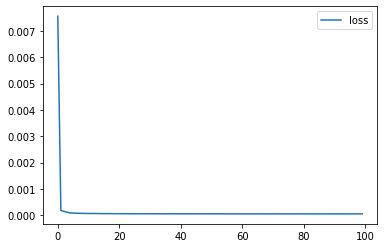

            predictions
2023-04-29     0.987836
2023-04-30     0.986782
2023-05-01     0.985351


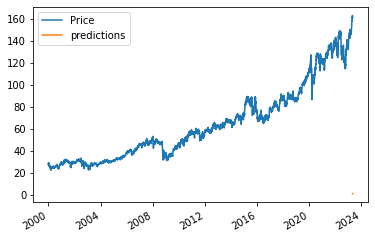

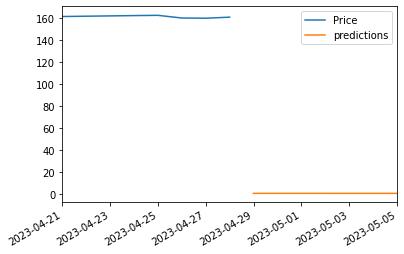

In [195]:
# Entrainement sur l'ensemble des données d'entrainement
print('-> création du modèle avec les paramètres ci-après:')
print(' early_stop: monitor:',monitor,', patience:',patience)
print('n_features: ',n_features)
print('epochs: ',n_epochs,'\n')

model.fit(generator, epochs=n_epochs,
        callbacks=[early_stop]) #, verbose=0)

# Evaluate the model on the test data
losses = pd.DataFrame(model.history.history)
losses.plot()
plt.show()

#mse, test_data_2 = evaluate_model_rnn(model, test_data, scaled_train, length, n_features, scaler)

# nombre de valeurs à prédire
periods = 7 
# les dates associées en partant du 1er jour qui suit le dernier jour des train
pred_index = pd.date_range(start=(pd.to_datetime(max(train_data.index)) + pd.Timedelta(days=1)).strftime('%Y-%m-%d'), periods=periods, freq='D')

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

valeurs_predites = []

for i in range(periods):
    # prediction avec 1 periode d'avance
    current_pred = model.predict(current_batch)[0]

    # stocker la prédiction
    valeurs_predites.append(current_pred) 

    # mise à jour du batch pour inclure maintenant la prédiction et supprimer la première valeur
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)        

predictions = pd.DataFrame(data=valeurs_predites, index=pred_index, columns=['predictions'])
print(predictions.head(3))


# Save the trained model
model.save("./models/full_trained_model.h5")

# Save the test data
dump(length, './data/length.joblib')
dump(n_features, './data/n_features.joblib')
dump(scaled_train, './data/full_scaled_train.joblib')        
dump(scaler, './data/scaler_full.joblib')

# tracer les données avec les prédictions sur la même courbe
ax = train_data.plot()
predictions.plot(ax=ax)
plt.show()                

# tracer les données avec les prédictions sur la même courbe (ZOOMER sur 10 jours avant et periods jours apres)
ax = train_data.plot()
predictions.plot(ax=ax)
debut_zoom = (pd.to_datetime(max(train_data.index)) - pd.Timedelta(days=7))
fin_zoom =  (pd.to_datetime(max(train_data.index)) + pd.Timedelta(days=periods))
plt.xlim(debut_zoom, fin_zoom)
plt.show()

Graphique

In [30]:
df.head(2)

,Open,High,Low,Close,Adj Close,Volume
2000-01-03,28.805216,30.005434,28.736633,28.976677,16.351425,1094181.0
2000-01-04,28.976677,28.925238,26.953453,27.690729,15.625772,1671548.0


In [33]:
df["Date"] = pd.to_datetime(df.Date)

Timestamp('2000-01-03 00:00:00')

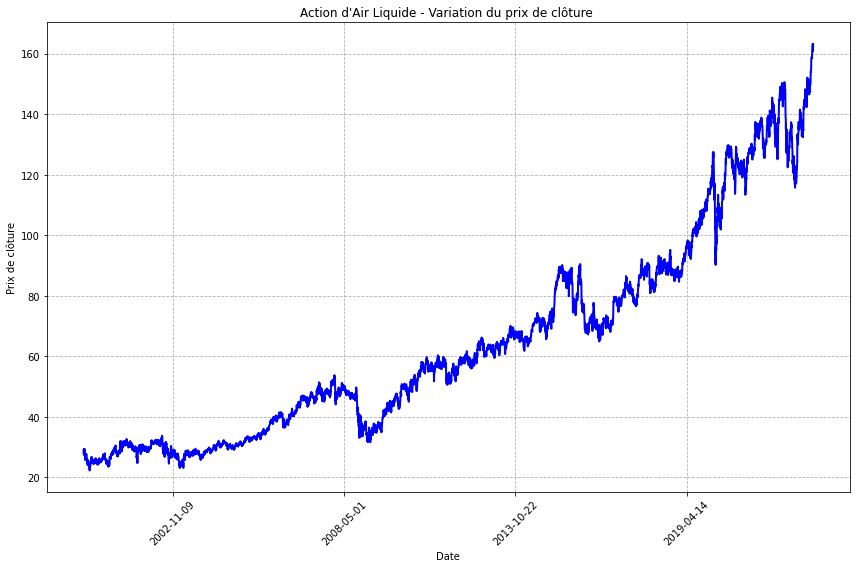

In [37]:
import matplotlib.pyplot as plt

# Définir les données à tracer
dates = df.index  # Assurez-vous que la colonne 'Date' est de type datetime
close_prices = df['Close']

# Créer la figure et les axes du graphique
fig, ax = plt.subplots(figsize=(12,8))

# Tracer le graphique
ax.plot(dates, close_prices, linewidth=2, color='blue')

# Ajouter des étiquettes et des titres
ax.set_xlabel('Date')
ax.set_ylabel('Prix de clôture')
ax.set_title('Action d\'Air Liquide - Variation du prix de clôture ')

# Formater les étiquettes de l'axe des dates
ax.xaxis.set_major_locator(plt.MaxNLocator(6))  # Affiche 6 étiquettes maximum
ax.xaxis.set_tick_params(rotation=45)  # Fait pivoter les étiquettes pour une meilleure lisibilité

# Afficher la grille en arrière-plan
ax.grid(True, linestyle='--')

# Afficher le graphique
plt.tight_layout()
plt.show()
